### Data Engineering

<b>Данные для обработки</b> - аналитика кликов и просмотров рекламы в рекламной компании (файл clickstream.parquet)

Структура данных:

<b>date</b>	день, в который происходят события

<b>time</b>	точное время события

<b>event</b>	тип события, может быть или пока или клик по рекламе

<b>platform	платформа</b>, на которой произошло рекламное событие

<b>ad_id</b>	id рекламного объявления

<b>client_union_id</b>	id рекламного клиента

<b>campaign_union_id</b>	id рекламной кампании

<b>ad_cost_type</b>	тип объявления с оплатой за клики (CPC) или за показы (CPM)

<b>ad_cost</b>	стоимость объявления в рублях, для CPC объявлений - это цена за клик, для CPM - цена за 1000 показов

<b>has_video</b>	есть ли у рекламного объявления видео

<b>target_audience_count</b>	размер аудитории, на которую таргетируется объявление

### Задача

Реализовать на PySpark задачу обработки данных для их подготовки к обучению моделей

В результате выполнения вашей задачи, например, выполнив команду:

<b>spark-submit PySparkJob.py clickstream.parquet result</b>

Вы должны прочитать указанный в параметрах файл, обработать его и получить структуру папок вида:

/result/train

/result/test

/result/validate

С наборами данных в следующем соотношении train/test/validate = 0.5/0.25/0.25 

In [1]:
import io
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, udf, lit
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

In [2]:
def _spark_session():
    return SparkSession.builder.appName('PySparkJob').getOrCreate()

In [3]:
spark=_spark_session()

In [7]:
spark

In [4]:
input_file=spark.read.parquet('clickstream.parquet')

In [5]:
input_file.printSchema()

root
 |-- date: date (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- event: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- ad_id: integer (nullable = true)
 |-- client_union_id: integer (nullable = true)
 |-- compaign_union_id: integer (nullable = true)
 |-- ad_cost_type: string (nullable = true)
 |-- ad_cost: double (nullable = true)
 |-- has_video: integer (nullable = true)
 |-- target_audience_count: decimal(10,0) (nullable = true)



### Подход 1 

(файл - PySparkJob1.py)

Добавляем к оригинальной таблице новые колонки , которые нужны для анализа.
Размер таблицы остается тот же (1 000 000 строк).
Далее делаем отбор нужных колонок.
В итоге из 1 000 000 строк отбираем примерно 1000, которую уже и разбиаем на треннировку , тест и валидацию.
Данное разбиение происходит довольно долго.
- Время выполнения терминальной операции после отбора нужных колнок - <b>1.5 минуты.</b>
- При разбиении на треннировку, тест, валидацию - общее время <b>4.5 минут.</b>

Данный подход оказывается медленным, но в итоге, при получении новой таблицы, мы сохраняем исходную размерность и можем проводить отбор альтернативного набора колонок, если в будущем будут другие задачи.

In [6]:
#определяем является ли тип объявления CPM
#указываем IntegerType, по умолчанию строка
func_is_cpm = udf(lambda x: 1 if x=='CPM' else 0,returnType=IntegerType())

#определяем является ли тип объявления CPC
#указываем IntegerType, по умолчанию строка
func_is_cpc = udf(lambda x: 1 if x=='CPC' else 0,returnType=IntegerType())

#добавляем колонку day_count
def func_day_count_add(input_file):
    
    #создаем DF - группируем исходный по ad_id, для событий с просмотрами,
    #находим для каждого ad_id timestamp первого и последнего просмотров
    df_timestamps=input_file.where(col('event')=='view').groupBy('ad_id')\
                              .agg(F.min('date').alias('timestamp_first_view'),\
                                   F.max('date').alias('timestamp_last_view'))
    
    #добавляем к созданному DF колонку с количеством дней, когда показывалась реклама,
    #считаем разницу в днях между первым и последним показом
    df_day_count=df_timestamps.withColumn('day_count',datediff( col('timestamp_last_view'),\
                                              col('timestamp_first_view') ))
    
    #делаем outer join исходного DF и колонки day_count из нового DF по ad_id, в результате для некоторых объявлений
    # в колонке day_count будут Null значения, что является маркером того, что для данного ad_id
    # в БД отражены события связанные с кликами
    df_joined=input_file.join(df_day_count, ['ad_id'], how='outer').orderBy('day_count').fillna({'day_count':0})
    
    return df_joined

#добавляем колонку CTR
def func_CTR_add(input_file):
    #создаем DF - группируя исходный DF по ad_id и считаем количество кликов для каждого  
    df_clicks=input_file.where(col('event')=='click').groupBy('ad_id').agg(F.count('event').alias('clicks_number'))
    
    #создаем DF - группируя исходный DF по ad_id и считаем количество показов для каждого  
    df_views=input_file.where(col('event')=='view').groupBy('ad_id').agg(F.count('event').alias('views_number'))
    
    #объединяем полученные DF-мы с исходным DF (т.е. добавляем 2 новые колонки - клики и показы), null в соответствующих
    #колонках заполняем 0-ми
    df_joined=input_file.join(df_clicks, ['ad_id'], how='outer')\
                        .join(df_views, ['ad_id'], how='outer')\
                        .fillna({'clicks_number':0,'views_number':0 })
    
    #добавляем колонку CTR к итоговому DF и переопределяем его с тем же именем
    df_joined=df_joined.withColumn('CTR',col('clicks_number')/col('views_number'))
    
    return df_joined

#последовательно добавляем все новые колонки, получаем итоговый DF
def transform_pipeline(input_file):
    
    #добавляем колонку day_count
    new_input_file=func_day_count_add(input_file)
    
    #добавляем колонку CTR
    new_input_file=func_CTR_add(new_input_file)
    
    #добавляем колонки is_cpm и is_cpc
    new_input_file=new_input_file.withColumn('is_cpm',  func_is_cpm(col('ad_cost_type')))\
                                 .withColumn('is_cpc',  func_is_cpc(col('ad_cost_type')))
    
    return new_input_file

#делаем разбиение, записываем результат по соответствующему пути
def get_result(DF, path):
    splits=DF.randomSplit([0.5,0.25,0.25],seed=0)
    
    splits[0].coalesce(1).write.option('header','true').parquet(str(path)+'/train')
    splits[1].coalesce(1).write.option('header','true').parquet(str(path)+'/test')
    splits[2].coalesce(1).write.option('header','true').parquet(str(path)+'/validate')

####  Создаем DF с заданной структурой:

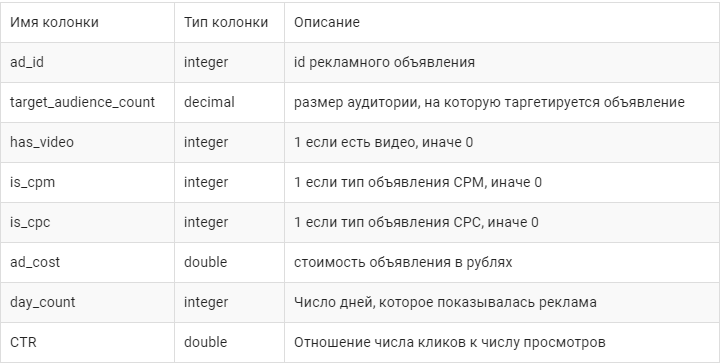

In [7]:
DF=transform_pipeline(input_file)[['ad_id','target_audience_count','has_video','is_cpm','is_cpc','ad_cost','day_count','CTR']]
DF.printSchema()

root
 |-- ad_id: integer (nullable = true)
 |-- target_audience_count: decimal(10,0) (nullable = true)
 |-- has_video: integer (nullable = true)
 |-- is_cpm: integer (nullable = true)
 |-- is_cpc: integer (nullable = true)
 |-- ad_cost: double (nullable = true)
 |-- day_count: integer (nullable = true)
 |-- CTR: double (nullable = true)



Проверяем время работы с помощью SQL + терминальная show()

In [89]:
DF.createOrReplaceTempView('DF')

In [108]:
%%time
spark.sql('SELECT DISTINCT ad_id, \
                  target_audience_count, \
                  has_video,\
                  is_cpm, \
                  is_cpc, \
                  ad_cost, \
                  day_count,\
                  CTR\
         FROM DF').show(4)

+-----+---------------------+---------+------+------+-------+---------+--------------------+
|ad_id|target_audience_count|has_video|is_cpm|is_cpc|ad_cost|day_count|                 CTR|
+-----+---------------------+---------+------+------+-------+---------+--------------------+
|38034|                40828|        0|     1|     0|  205.6|        1| 0.00586756077116513|
|27845|                51515|        0|     1|     0|  210.1|        1| 0.01276595744680851|
|29978|                26280|        0|     1|     0|  209.4|        1|0.018726591760299626|
|26250|                67416|        0|     1|     0|  209.5|        1|                 0.0|
+-----+---------------------+---------+------+------+-------+---------+--------------------+
only showing top 4 rows

Wall time: 1min 34s


Проверяем время работы с помощью distinct() + терминальная show()

In [109]:
%%time
DF.distinct().show(4)

+------+---------------------+---------+------+------+-------+---------+-------------------+
| ad_id|target_audience_count|has_video|is_cpm|is_cpc|ad_cost|day_count|                CTR|
+------+---------------------+---------+------+------+-------+---------+-------------------+
| 46071|               207759|        0|     1|     0|  221.6|        1|                0.0|
| 34633|                 1406|        0|     1|     0|  195.9|        1|0.05263157894736842|
|120127|                 4515|        0|     1|     0|  194.1|        1|0.08108108108108109|
|118186|                56578|        0|     1|     0|  206.7|        1|                0.0|
+------+---------------------+---------+------+------+-------+---------+-------------------+
only showing top 4 rows

Wall time: 1min 28s


Делаем разбиение на train/test/validate с помщью randomSplit и записываем результат по указанному пути

In [112]:
%%time
get_result(DF.distinct(),'RESULTAT')

Wall time: 4min 38s


### Подход 2

(файл PySparkJob2.py)

В предыдущем подходе низкое быстродествие обусловленно тем, что мы собирали итоговую таблицу делая полный джойн при добавлении каждой из колонок, в результате чего, после отбора нужных колонок в таблицы было много джубликатов, удаление которых занимает много времени.

Альтернативный вариант - последовательно создаем новые колонки путем группировки по ad_id и собираем их в новую таблицу небольшого размера, в конечной итерации делаем джойн с колонками из исходной таблицы.

Такой подход имеет значительно более высокое быстродействие.

- При разбиении на треннировку, тест, валидацию - общее время <b>18 сек</b>

In [21]:
#создаем новый DF из исходного, получаем day_count колонку
def func_day_count_DF(input_file):
    
    #создаем DF - группируем исходный по ad_id, для событий с просмотрами,
    #находим для каждого ad_id timestamp первого и последнего просмотров
    df_timestamps=input_file.where(col('event')=='view').groupBy('ad_id')\
                              .agg(F.min('date').alias('timestamp_first_view'),\
                                   F.max('date').alias('timestamp_last_view'))
    
    #добавляем к созданному DF колонку с количеством дней, когда показывалась реклама,
    #считаем разницу в днях между первым и последним показом
    df_day_count=df_timestamps.withColumn('day_count',datediff( col('timestamp_last_view'),\
                                              col('timestamp_first_view') ))
    
    #оставляем только нужные колонки для последующих операций ad_id и day_count
    df_day_count=df_day_count.drop('timestamp_first_view','timestamp_last_view')
    
    #получаем 956 строк - ad_id, для которых были просмотры (в данный DF не вошли ad_id, для которых
    #есть клики, но нет просмотров)
    return df_day_count

#создаем новый DF из исходного, получаем CTR колонку
def func_CTR_DF(input_file):
    #создаем DF - группируя исходный DF по ad_id и считаем количество кликов для каждого  
    df_clicks=input_file.where(col('event')=='click').groupBy('ad_id').agg(F.count('event').alias('clicks_number'))
    
    #создаем DF - группируя исходный DF по ad_id и считаем количество показов для каждого  
    df_views=input_file.where(col('event')=='view').groupBy('ad_id').agg(F.count('event').alias('views_number'))
    
    #объединяем полученные DF-мы с исходным DF (т.е. добавляем 2 новые колонки - клики и показы), null в соответствующих
    #колонках заполняем 0-ми
    df_CTR=df_clicks.join(df_views, ['ad_id'], how='outer')\
                        .fillna({'clicks_number':0,'views_number':0 })
    
    #добавляем колонку CTR к полученному DF и переопределяем его с тем же именем, null заменяем бесконечностью
    #по идее на данном этапе строки с null уже можно удалить
    df_CTR=df_CTR.withColumn('CTR',col('clicks_number')/col('views_number'))\
                        .fillna({'CTR':float('inf')})
    
    #оставляем только нужные колонки
    df_CTR=df_CTR.drop('clicks_number','views_number')
    
    return df_CTR


#определяем является ли тип объявления CPM
#указываем IntegerType, по умолчанию строка
func_is_cpm = udf(lambda x: 1 if x=='CPM' else 0,returnType=IntegerType())

#определяем является ли тип объявления CPC
#указываем IntegerType, по умолчанию строка
func_is_cpc = udf(lambda x: 1 if x=='CPC' else 0,returnType=IntegerType())

#собираем все преобразования в одну функцию
def func_joining(input_file):
    
    #получаем day_count колонку
    df_day_count=func_day_count_DF(input_file)
    
    #получаем CTR колонку
    df_CTR=func_CTR_DF(input_file)
    
    #добавляем к исходному DF колонки is_cpm и is_cpc используя udf (данный DF содержит 1 000 000)
    new_input_file=input_file.withColumn('is_cpm',  func_is_cpm(col('ad_cost_type')))\
                                 .withColumn('is_cpc',  func_is_cpc(col('ad_cost_type')))
    
    
    #объединяем df_day_count и df_CTR, далее добавляем нужные колонки из new_input_file 
    Result_DF=df_day_count.join(df_CTR,['ad_id'], how='outer')\
                                       .join(new_input_file[['ad_id',
                                                             'ad_cost',
                                                             'target_audience_count',
                                                             'has_video',
                                                             'is_cpm',
                                                             'is_cpc']], ['ad_id'],how='outer')

    
    return Result_DF

#делаем разбиение, записываем результат по соответствующему пути
def get_result(DF, path):
    splits=DF.randomSplit([0.5,0.25,0.25],seed=0)
    
    splits[0].coalesce(1).write.option('header','true').parquet(str(path)+'/train')
    splits[1].coalesce(1).write.option('header','true').parquet(str(path)+'/test')
    splits[2].coalesce(1).write.option('header','true').parquet(str(path)+'/validate')

####  Создаем DF с заданной структурой:

In [19]:
%%time
DF2=func_joining(input_file)[['ad_id','target_audience_count','has_video','is_cpm','is_cpc','ad_cost','day_count','CTR']]
DF2.printSchema()

root
 |-- ad_id: integer (nullable = true)
 |-- target_audience_count: decimal(10,0) (nullable = true)
 |-- has_video: integer (nullable = true)
 |-- is_cpm: integer (nullable = true)
 |-- is_cpc: integer (nullable = true)
 |-- ad_cost: double (nullable = true)
 |-- day_count: integer (nullable = true)
 |-- CTR: double (nullable = true)

Wall time: 195 ms


In [20]:
%%time
DF2.distinct().show(4)

+------+---------------------+---------+------+------+-------+---------+--------------------+
| ad_id|target_audience_count|has_video|is_cpm|is_cpc|ad_cost|day_count|                 CTR|
+------+---------------------+---------+------+------+-------+---------+--------------------+
| 43967|                39676|        0|     1|     0|  205.6|        1|                 0.0|
| 15926|                87378|        0|     1|     0|  188.3|        1|0.005882352941176...|
| 25419|                68355|        0|     1|     0|  191.2|        1|                 0.0|
|114019|               265581|        0|     1|     0|  194.5|        1|                 0.0|
+------+---------------------+---------+------+------+-------+---------+--------------------+
only showing top 4 rows

Wall time: 5.5 s


Делаем разбиение на train/test/validate с помщью randomSplit и записываем результат по указанному пути

In [22]:
%%time
get_result(DF2.distinct(),'RESULTAT_RES')

Wall time: 18 s


Проверяем, что оба подхода создают нам одинаковые DF (проверяем итоговую, исходную размерность, схемы)

#### Подход 2

In [11]:
%%time
DF2.distinct().count()

Wall time: 7.69 s


965

#### Подход 1

In [13]:
%%time
DF.distinct().count()

Wall time: 1min 28s


965

In [14]:
DF2.printSchema()

root
 |-- ad_id: integer (nullable = true)
 |-- target_audience_count: decimal(10,0) (nullable = true)
 |-- has_video: integer (nullable = true)
 |-- is_cpm: integer (nullable = true)
 |-- is_cpc: integer (nullable = true)
 |-- ad_cost: double (nullable = true)
 |-- day_count: integer (nullable = true)
 |-- CTR: double (nullable = true)



In [15]:
DF.printSchema()

root
 |-- ad_id: integer (nullable = true)
 |-- target_audience_count: decimal(10,0) (nullable = true)
 |-- has_video: integer (nullable = true)
 |-- is_cpm: integer (nullable = true)
 |-- is_cpc: integer (nullable = true)
 |-- ad_cost: double (nullable = true)
 |-- day_count: integer (nullable = true)
 |-- CTR: double (nullable = true)



In [18]:
print(DF.count())
print(DF2.count())

1000000
1000000
